In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import conv_architecture_ala_nips_17, default_train_params_ala_nips_17
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from pc_completions.evaluation import basic_comletion_measures

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))

In [47]:
# # train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt')
# # val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt')
# # test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt')

# # train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/train.txt')
# # val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/val.txt')
# # test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/test.txt')


train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/val.txt')
test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/test.txt')


In [21]:
do_training = True
load_pretrained_model = False
load_epoch = None
random_seed = 42
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=random_seed)

In [22]:
bneck_size = 32
loss = 'chamfer'

In [48]:
tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=20, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

test_files = splitter.load_splits(test_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(test_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

3500 pclouds were loaded. They belong in 7 shape-classes.
350 pclouds were loaded. They belong in 7 shape-classes.
700 pclouds were loaded. They belong in 7 shape-classes.


In [1]:
from geo_tool.in_out.soup import load_crude_point_cloud
def fps_loader(in_f):
    pc = load_crude_point_cloud(in_f)
    pc = Point_Cloud(pc).permute_points([0,2,1]).points
    syn_id = in_f.split('/')[-3]
    model_name = in_f.split('/')[-2]
    return pc, model_name, syn_id

verbose = True
n_threads = 20

tr_files_dir = '/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Core/fps_on_manifold_meshes/wu_small/20000/train/'
tr_f = [f for f in files_in_subdirs(tr_files_dir, '.pts')]
pc, model_names, labels = load_point_clouds_from_filenames(tr_f, n_threads, fps_loader, verbose)
train_data = PointCloudDataSet(pc, labels=model_names)

val_files_dir = '/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Core/fps_on_manifold_meshes/wu_small/20000/val/'
val_f = [f for f in files_in_subdirs(val_files_dir, '.pts')]
pc, model_names, labels = load_point_clouds_from_filenames(val_f, n_threads, fps_loader, verbose)
val_data = PointCloudDataSet(pc, labels=model_names)


NameError: name 'files_in_subdirs' is not defined

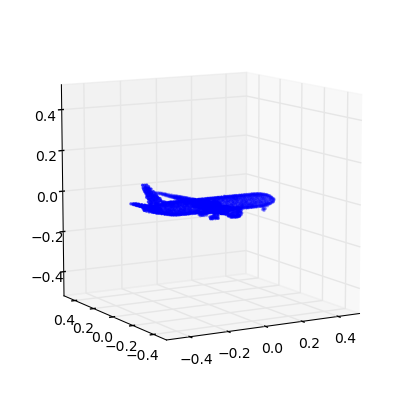

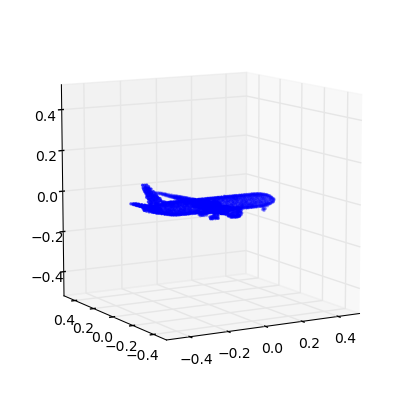

In [31]:
# Point_Cloud(train_data.point_clouds[88]).plot()

In [32]:
from tflearn.layers.conv import avg_pool_1d, max_pool_1d
from tflearn.layers.core import fully_connected, dropout
from tflearn.layers.conv import conv_1d
from tflearn.layers.normalization import batch_normalization
from tf_lab.fundamentals.utils import expand_scope_by_name, replicate_parameter_for_all_layers
from functools import partial

In [33]:
def encoder_with_convs_and_pool(in_signal, n_filters=[64, 128, 256, 1024], filter_sizes=[1], strides=[1],
                                    b_norm=True, spn=False, non_linearity=tf.nn.relu, regularizer=None, weight_decay=0.001,
                                    symmetry=tf.reduce_max, dropout_prob=None, pool=None, pool_sizes=None, scope=None, reuse=False):
    '''An Encoder (recognition network), which maps inputs onto a latent space.
    '''
    n_layers = len(n_filters)
    filter_sizes = replicate_parameter_for_all_layers(filter_sizes, n_layers)
    strides = replicate_parameter_for_all_layers(strides, n_layers)
    dropout_prob = replicate_parameter_for_all_layers(dropout_prob, n_layers)

    if n_layers < 2:
        raise ValueError('More than 1 layers are expected.')

    if spn:
        raise NotImplementedError('')
    
    print n_filters
    print filter_sizes
    print pool_sizes
        
    for i in xrange(n_layers):
        if i == 0:
            layer = in_signal
        
        name = 'encoder_conv_layer_' + str(i)
        scope_i = expand_scope_by_name(scope, name)
        layer = conv_1d(layer, nb_filter=n_filters[i], filter_size=filter_sizes[i], strides=strides[i], regularizer=regularizer, weight_decay=weight_decay, name=name, reuse=reuse, scope=scope_i)

        if b_norm:
            name += '_bnorm'
            scope_i = expand_scope_by_name(scope, name)
            layer = batch_normalization(layer, name=name, reuse=reuse, scope=scope_i)

        layer = non_linearity(layer)

        if pool is not None:
            if pool_sizes[i] is not None:
                layer = pool(layer, kernel_size=pool_sizes[i])

        if dropout_prob is not None and dropout_prob[i] > 0:
            layer = dropout(layer, 1.0 - dropout_prob[i])
            
        print layer, np.prod(layer.get_shape().as_list()[1:])
        
    if symmetry is not None:
        layer = symmetry(layer, axis=1)
        print layer, np.prod(layer.get_shape().as_list()[1:])
        
    return layer

In [34]:
b_norm = True
decoder_args = {'layer_sizes': [bneck_size, 512, 1024, n_pc_points*3], 'b_norm': b_norm}

In [35]:
encoder_args = {'n_filters': [128, 256, 256, 512, 512],
                'filter_sizes': [9, 6, 3, 2, 1],
                'strides': [2, 2, 1, 1, 1],
                'b_norm': b_norm,
                'pool': avg_pool_1d,
                'pool_sizes': [2, None, 2, None, 2],
                'symmetry': None
                }

In [36]:
v = 1
v = str(v)

In [37]:
experiment_id = 'neighborhood_size_v_' + v
experiment_name = '_'.join(['chair', 'exp', experiment_id, str(n_pc_points),
                            'pts_bneck', str(bneck_size), loss
                           ])

train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer'

In [38]:
if load_pretrained_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    if conf.train_dir != train_dir:
        conf.train_dir = train_dir
    conf.save(osp.join(train_dir, 'configuration'))
else:
    conf = Conf(
                n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 100,
                batch_size = 50,
                denoising = False,
                learning_rate = 0.0005,
                train_dir = train_dir,             
                loss_display_step = 1,
                saver_step = None ,
                z_rotate = False,
                encoder = encoder_with_convs_and_pool, 
                decoder = decoder_with_fc_only,
                encoder_args = encoder_args,
                decoder_args = decoder_args
               )
    
    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [49]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
print ae.trainable_parameters()

[128, 256, 256, 512, 512]
[9, 6, 3, 2, 1]
[2, None, 2, None, 2]
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D/Squeeze:0", shape=(?, 512, 128), dtype=float32) 65536
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/Relu_1:0", shape=(?, 256, 256), dtype=float32) 65536
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D_1/Squeeze:0", shape=(?, 128, 256), dtype=float32) 32768
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/Relu_3:0", shape=(?, 128, 512), dtype=float32) 65536
Tensor("chair_exp_neighborhood_size_v_1_2048_pts_bneck_32_chamfer_1/AvgPool1D_2/Squeeze:0", shape=(?, 64, 512), dtype=float32) 32768
8817504


In [50]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)    
    train_stats = ae.train(train_data, conf, log_file=fout, held_out_data=val_data)
    fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.0396', 'loss=', '0.016668605')
('Epoch:', '0002', 'training time (minutes)=', '0.0366', 'loss=', '0.004169052')
('Epoch:', '0003', 'training time (minutes)=', '0.0373', 'loss=', '0.003618320')
('Epoch:', '0004', 'training time (minutes)=', '0.0370', 'loss=', '0.003375445')
('Epoch:', '0005', 'training time (minutes)=', '0.0372', 'loss=', '0.003266793')
('Held Out Data :', 'forward time (minutes)=', '0.0032', 'loss=', '0.003215344')
('Epoch:', '0006', 'training time (minutes)=', '0.0370', 'loss=', '0.003036168')
('Epoch:', '0007', 'training time (minutes)=', '0.0372', 'loss=', '0.002717695')
('Epoch:', '0008', 'training time (minutes)=', '0.0375', 'loss=', '0.002667180')
('Epoch:', '0009', 'training time (minutes)=', '0.0372', 'loss=', '0.002771731')
('Epoch:', '0010', 'training time (minutes)=', '0.0376', 'loss=', '0.002489211')
('Held Out Data :', 'forward time (minutes)=', '0.0023', 'loss=', '0.002406043')
('Epoch:', '0011', 'training

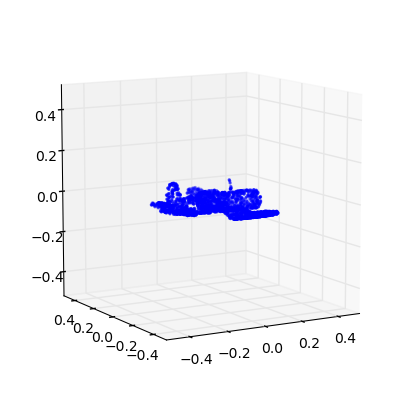

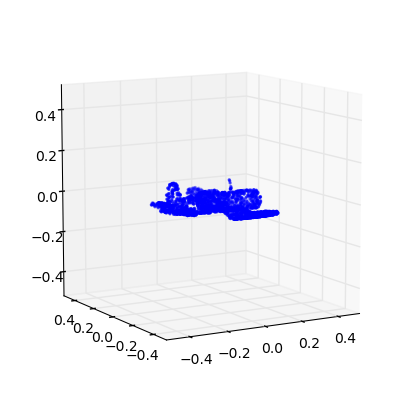

In [60]:
Point_Cloud(train_data.point_clouds[8]).plot()